In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **資料預處理**

In [ ]:
from zipfile import ZipFile
path = "/content/drive/MyDrive/ttgroup/0_9000/0519_out_resize256x256_0_9000_skeleton.zip"
f = ZipFile(path)
# f.extractall() 小括號是直接解壓縮在同一層
f.extractall()

In [ ]:
# 製作igm_name的list
import glob
import pandas as pd
import numpy as np

# sorted() : 排序所有可跌代對象
# split() : 分割()
fn_dic = {"img_name":[]}
paths = sorted(glob.glob("0519_out_resize256x256_0_9000_skeleton/*"))
for path in paths:
  fn = path.split("/")[-1].split(".")[0]
  fn_dic["img_name"].append(fn)
fn_dic_df = pd.DataFrame(fn_dic)
fn_dic_df

,img_name
0,0004
1,0044
2,0070
3,0089
4,0095
...,...
580,8868
581,8872
582,8877
583,8903


In [ ]:
# img_combine_arr 訓練資料DataFarme (x_train, x_test)
from PIL import Image
fn_list = fn_dic["img_name"]

# # RGB寫法
img_arr_list = []
for fn in fn_list:
  img = Image.open("0519_out_resize256x256_0_9000_skeleton/" + fn + ".jpg").convert("RGB")
  img = img.resize((256, 256))
  globals()["img_"+ fn] = img
  globals()["img_"+ fn + "_arr"] = np.array(globals()["img_"+fn])
  img_arr_list.append(globals()["img_"+ fn + "_arr"])
  img.close()
# img_arr_list = ()
img_combine_arr = np.array(img_arr_list)
img_combine_arr.shape
# img_combine_arr[0]

(585, 256, 256, 3)

In [ ]:
# ans_df  驗證資料DataFrame (y_train, y_test)
base = "/content/drive/MyDrive/ttgroup/0_9000/0519_wrong_total_sit_value_combinefoot_0_9000.csv"
csv = pd.read_csv(base, sep=",")
# df.drop(['B', 'C'], axis=1)
# ans_df.drop(['img_name'], axis=1)
ans_df = pd.DataFrame(csv)


In [ ]:
# 切割資料 x_train, x_test, y_train, y_test
from sklearn.model_selection import train_test_split
import numpy as np
x_train, x_test, y_train, y_test = train_test_split(img_combine_arr,
                             np.array(ans_df),
                             test_size=0.1)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(526, 256, 256, 3)
(526, 4)
(59, 256, 256, 3)
(59, 4)


In [ ]:
# 將image_name 的y_train, y_test 拿出來
y_train_imn_df = pd.DataFrame(y_train)[0]
y_test_imn_df = pd.DataFrame(y_test)[0]


# 將訓練跟測試答案 拿出來
# .drop(['img_name'], axis=1)
y_train_df = pd.DataFrame(y_train).drop([0], axis=1)
y_test_df = pd.DataFrame(y_test).drop([0], axis=1)
# y_train_df.shape
# y_test_df.shape
# print(len(y_test_df))
# 將訓練跟測試的答案 轉回arr,並命名回 y_train, y_test
y_train = np.array(y_train_df)
y_test = np.array(y_test_df)


240
[1 1 1]


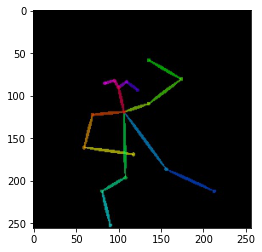

In [ ]:
# 顯示圖片和標籤
import random
import matplotlib.pyplot as plt
idx = random.randint(0, 260)
print(idx)
print(y_train[idx])
plt.imshow(x_train[idx])

# **模型建置**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
layers = [
    Conv2D(64, 3, padding="same", activation="relu", input_shape=(256, 256, 3)),
    MaxPooling2D(),
    Conv2D(128, 3, padding="same", activation="relu"),
    MaxPooling2D(),
    Conv2D(256, 3, padding="same", activation="relu"),
    MaxPooling2D(),
    Conv2D(512, 3, padding="same", activation="relu"),
    GlobalAveragePooling2D(),
    Dense(3, activation="sigmoid")
]
model = Sequential(layers)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 128, 128, 128)     73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 64, 256)       295168    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 512)      

In [ ]:
from tensorflow.keras.losses import BinaryCrossentropy
model.compile(loss=BinaryCrossentropy(),
       optimizer="adam",
       metrics=["accuracy"])

In [ ]:
x_train_norm = x_train / 255
x_test_norm = x_test / 255

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
callbacks = [
   EarlyStopping(patience=5, restore_best_weights=True),
   ModelCheckpoint("cnn.h5", save_best_only=True) 
]

model.fit(x_train_norm,
     y_train,
     batch_size=20,
     epochs=50,
     validation_split=0.1,
     verbose=2,
     callbacks=callbacks)

Epoch 1/50
24/24 - 3s - loss: 0.5805 - accuracy: 0.2537 - val_loss: 0.5305 - val_accuracy: 0.2453
Epoch 2/50
24/24 - 2s - loss: 0.5550 - accuracy: 0.2368 - val_loss: 0.5188 - val_accuracy: 0.2453
Epoch 3/50
24/24 - 2s - loss: 0.5525 - accuracy: 0.5391 - val_loss: 0.5258 - val_accuracy: 0.2453
Epoch 4/50
24/24 - 2s - loss: 0.5528 - accuracy: 0.1987 - val_loss: 0.5192 - val_accuracy: 0.2453
Epoch 5/50
24/24 - 2s - loss: 0.5473 - accuracy: 0.2008 - val_loss: 0.5163 - val_accuracy: 0.2453
Epoch 6/50
24/24 - 2s - loss: 0.5396 - accuracy: 0.2030 - val_loss: 0.5148 - val_accuracy: 0.2453
Epoch 7/50
24/24 - 2s - loss: 0.5355 - accuracy: 0.2812 - val_loss: 0.5098 - val_accuracy: 0.2642
Epoch 8/50
24/24 - 2s - loss: 0.5249 - accuracy: 0.3002 - val_loss: 0.4964 - val_accuracy: 0.3585
Epoch 9/50
24/24 - 2s - loss: 0.5029 - accuracy: 0.3742 - val_loss: 0.5146 - val_accuracy: 0.6226
Epoch 10/50
24/24 - 2s - loss: 0.4964 - accuracy: 0.4101 - val_loss: 0.5314 - val_accuracy: 0.6604
Epoch 11/50
24/24 -

In [ ]:
model.evaluate(x_test_norm, y_test)

2/2 [==============================] - 0s 36ms/step - loss: 0.4973 - accuracy: 0.3559


[0.4972800016403198, 0.35593220591545105]

In [ ]:
pre = model.predict(x_test_norm)
# pre.shape
pre.shape
pre_list = pre.tolist()

y_test.tolist()

[[1, 0, 0],
 [1, 0, 1],
 [1, 0, 1],
 [1, 0, 1],
 [1, 0, 1],
 [0, 0, 1],
 [1, 0, 0],
 [1, 1, 0],
 [0, 0, 1],
 [1, 1, 1],
 [1, 1, 1],
 [0, 0, 1],
 [1, 0, 1],
 [1, 0, 0],
 [1, 0, 1],
 [1, 0, 1],
 [1, 1, 0],
 [1, 1, 1],
 [0, 0, 1],
 [1, 0, 1],
 [1, 0, 1],
 [1, 0, 0],
 [1, 0, 1],
 [1, 0, 1],
 [1, 0, 1],
 [0, 0, 1],
 [1, 1, 1],
 [1, 0, 0],
 [0, 0, 1],
 [1, 1, 1],
 [0, 0, 1],
 [0, 0, 1],
 [1, 0, 1],
 [1, 0, 1],
 [0, 0, 1],
 [1, 0, 1],
 [1, 1, 1],
 [1, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [1, 1, 1],
 [1, 0, 1],
 [1, 0, 1],
 [1, 1, 1],
 [1, 0, 1],
 [1, 1, 0],
 [0, 0, 1],
 [1, 0, 1],
 [1, 1, 1],
 [1, 0, 1],
 [1, 1, 1],
 [1, 1, 1],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 1],
 [1, 1, 1],
 [1, 1, 1],
 [0, 0, 1],
 [1, 0, 1]]

In [ ]:
# check wrong pics 

# 製作預測機率值的dic
pre = model.predict(x_test_norm)
pre_list = pre.tolist()
# pre_dic = {}
# for i ,pre in enumerate(pre_list):
#   pre_dic[i] = [round(p, 3)for p in pre] 
Proba_dic = {i:[round(p, 3)for p in pre] for i ,pre in enumerate(pre_list)}

# 製作預測答案的dic
pre_round_dic = {i:[round(p)for p in pre] for i ,pre in enumerate(pre_list)}
# print(pre_round_dic)

# 製作答案的dic
y_test_list = y_test.tolist()
y_test_dic = {i:pre for i, pre in enumerate(y_test_list)}
# print(y_test_dic)

Proba_dic_value_list = list(Proba_dic.values())
pre_round_value_list = list(pre_round_dic.values())
y_test_value_list = list(y_test_dic.values())
# print("y_test_ans", y_test_dic.values())
# print(pre_value_list)
count = 0
for i in range(len(y_test_list)): 
  if pre_round_value_list[i] != y_test_value_list[i]:
    print("pic_name:", y_test_imn_df[i], 
       ",Proba:", Proba_dic_value_list[i],
       ",pre_value:", pre_round_value_list[i], 
       ",y_test_value:", y_test_value_list[i])
    count += 1

# error_ratio
# {:.2%}： 显示小数点后2位
# >>> print('percent: {:.2%}'.format(42/50))
# 不显示小数位：{:.0%}，即，将2改为0：
# >>> print('percent: {:.0%}'.format(42/50))
error_ratio = 'error_ratio: {:.0%}'.format(count/len(y_test_list))
print("error_pics:" + str(count)+ "\n"+ "total_pics:"+ str(len(y_test_list)) +"\n"+ error_ratio)

pic_name: 4879 ,Proba: [0.841, 0.246, 0.645] ,pre_value: [1, 0, 1] ,y_test_value: [1, 0, 0]
pic_name: 4579 ,Proba: [0.798, 0.253, 0.78] ,pre_value: [1, 0, 1] ,y_test_value: [0, 0, 1]
pic_name: 1430 ,Proba: [0.734, 0.251, 0.949] ,pre_value: [1, 0, 1] ,y_test_value: [1, 1, 0]
pic_name: 2051 ,Proba: [0.69, 0.241, 0.788] ,pre_value: [1, 0, 1] ,y_test_value: [0, 0, 1]
pic_name: 7362 ,Proba: [0.696, 0.265, 0.983] ,pre_value: [1, 0, 1] ,y_test_value: [1, 1, 1]
pic_name: 6846 ,Proba: [0.687, 0.265, 0.974] ,pre_value: [1, 0, 1] ,y_test_value: [1, 1, 1]
pic_name: 5600 ,Proba: [0.772, 0.235, 0.577] ,pre_value: [1, 0, 1] ,y_test_value: [0, 0, 1]
pic_name: 8597 ,Proba: [0.791, 0.234, 0.404] ,pre_value: [1, 0, 0] ,y_test_value: [1, 0, 1]
pic_name: 3288 ,Proba: [0.709, 0.251, 0.887] ,pre_value: [1, 0, 1] ,y_test_value: [1, 0, 0]
pic_name: 8608 ,Proba: [0.91, 0.227, 0.101] ,pre_value: [1, 0, 0] ,y_test_value: [1, 1, 0]
pic_name: 1529 ,Proba: [0.789, 0.265, 0.939] ,pre_value: [1, 0, 1] ,y_test_value: [

In [ ]:
# 將上述的錯誤圖片,用DataFrame 做排序
pic_info_dic = {"Pic_name":[],
         "Proba":[],
         "pre_value":[],
         "y_test_value":[]
        }
for i in range(len(y_test_list)): 
  if pre_round_value_list[i] != y_test_value_list[i]:
    pic_info_dic["Pic_name"].append(y_test_imn_df[i])
    pic_info_dic["Proba"].append(Proba_dic_value_list[i])
    pic_info_dic["pre_value"].append(pre_round_value_list[i])
    pic_info_dic["y_test_value"].append(y_test_value_list[i])
pic_info_dic_df = pd.DataFrame(pic_info_dic)
pic_info_dic_s_df = pic_info_dic_df.sort_values(by=["Pic_name"], ignore_index=True)
pic_info_dic_s_df

,Pic_name,Proba,pre_value,y_test_value
0,44,"[0.702, 0.268, 0.987]","[1, 0, 1]","[1, 1, 1]"
1,313,"[0.69, 0.251, 0.934]","[1, 0, 1]","[0, 0, 1]"
2,393,"[0.684, 0.254, 0.935]","[1, 0, 1]","[1, 1, 1]"
3,1174,"[0.719, 0.233, 0.55]","[1, 0, 1]","[0, 0, 1]"
4,1299,"[0.808, 0.231, 0.292]","[1, 0, 0]","[1, 1, 1]"
5,1409,"[0.685, 0.262, 0.973]","[1, 0, 1]","[1, 1, 1]"
6,1430,"[0.734, 0.251, 0.949]","[1, 0, 1]","[1, 1, 0]"
7,1529,"[0.789, 0.265, 0.939]","[1, 0, 1]","[1, 1, 1]"
8,2051,"[0.69, 0.241, 0.788]","[1, 0, 1]","[0, 0, 1]"
9,2133,"[0.673, 0.279, 0.988]","[1, 0, 1]","[1, 1, 1]"


In [ ]:
# x_test_norm[0].shape
# x_test_nomr_re = x_test_norm[0].reshape(1,256,256,3)
# ans_names = ans_df.columns.tolist()

In [ ]:
# import pandas as pd
# from sklearn.metrics import confusion_matrix
# mat = confusion_matrix(y_test, pre)
# pd.DataFrame(mat,
#        columns=[y_train[i] + "(預測)" for i in range(10)],
#        index=[y_train[i] + "(正確)" for i in range(10)])

In [ ]:
from PIL import Image
# RGB, RGBA, L(gray)
fn = input("輸入檔名:")
img = Image.open(fn).resize((256, 256)).convert("RGB")
img_np = np.array(img)
img_np_r = img_np.reshape(1, 256, 256, 3) / 255.0
pre = model.predict(img_np_r)[0]

pre_list = pre.tolist()
print("預測數值", pre_list)

ans_names = ans_df.columns.tolist()
ans_list = []
for i, ans_name in enumerate(ans_names):
  ans = round(pre_list[i])
  ans_list.append(ans)
print("T&F:", ans_list)

correct = []
wrong = []
for i, ans_val in enumerate(ans_list):
  if ans_val == 1:
    wrong.append(ans_names[i])
  else:
    correct.append(ans_names[i])
print("correct:", correct)
print("wrong:", wrong)
plt.imshow(img_np)

KeyboardInterrupt: ignored